# Project 2

## MSDS7331: Data Mining
## Section 0403
## Summer 2018
- Anthony Schams
- Laura Ludwig  
- David Stroud
- Joshua Balson

## Data Preparation 
### Data Preparation Part 1
#### Define and Prepare Class Variables

##### Import Necessary packages

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import datetime as dt
import warnings
import string
import time
from __future__ import print_function
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict,GridSearchCV, ShuffleSplit,StratifiedShuffleSplit 
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics as mt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier


##### Import the data

In [3]:


df_train = pd.read_csv('train.csv')
df_resources = pd.read_csv('resources.csv')
train_resource = pd.merge(df_train, df_resources, on="id", how='left')
df_train[df_train.teacher_prefix.isnull()]
train_resource[train_resource.description.isnull()].head()
t2 = train_resource.pivot_table(index = ['id', 'description'],
                                values='quantity', 
                                aggfunc=np.sum)
t2.reset_index(inplace=True)
train_resource = pd.merge(train_resource,
                          t2, 
                          on=['id', 'description'], 
                          how='right',
                          suffixes=('_Orig', '_True'))

train_resource = train_resource.drop_duplicates()
train_resource = train_resource.drop('quantity_Orig', axis=1)
train_resource = train_resource.rename(columns={'quantity_True': 'True_Quantity'})
train_resource['Total_Cost'] = train_resource.price * train_resource.True_Quantity
Total_cost = train_resource.pivot_table(values=['Total_Cost','True_Quantity'],
                                        index='id',
                                        aggfunc={'Total_Cost' : np.sum, 'True_Quantity' : np.sum})
Total_cost.reset_index(level=0, inplace = True)

df_train = df_train.merge(Total_cost, on='id', how='left')
df_train['Average_item_cost'] = df_train.Total_Cost  / df_train.True_Quantity

df_train['text'] = df_train.apply(lambda row: ' '.join([str(row['project_essay_1']), 
                                                        str(row['project_essay_2']), 
                                                        str(row['project_essay_3']), 
                                                        str(row['project_essay_4'])]), axis=1
                                                      )                               

df = df_train

stop_words = list(set(stopwords.words('english')))
warnings.filterwarnings('ignore')
punctuation = string.punctuation

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182080 entries, 0 to 182079
Data columns (total 20 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

#### Variable Clean-up

Due to a change in the application questions, we must combine the responses for two questions in the earlier period to equate to one response in the later period. Prior to the change, the first two questions asked the teacher to introduce their students using two questions: one about their classroom and another describing their students. The later format has one question requesting the teacher to describe their students. The third and fourth questions in the prior period asked about the project details, which is addressed in the second question in the later period. We combined the text to create two variables: student_desc and proj_desc, to capture these two topics in comparable variables. Once we've created those, we remove the project_essay_x variables from the dataframe.  

In [4]:
# Create comparable variables based on the changes to the application questions that happened during the middle of the time period
df['student_desc'] = np.where(df['project_submitted_datetime']<'2016-05-17',df['project_essay_1']+' '+df['project_essay_2'],df['project_essay_1'])
df['proj_desc'] = np.where(df['project_submitted_datetime']<'2016-05-17',df['project_essay_3']+' '+df['project_essay_4'],df['project_essay_2'])

# Remove attributes that arent useful
if 'project_essay_1' in df:
    del df['project_essay_1']
if 'project_essay_2' in df:    
    del df['project_essay_2']
if 'project_essay_3' in df:
    del df['project_essay_3']
if 'project_essay_4' in df:    
    del df['project_essay_4']

Because one of our analysis tasks is to predict whether we can identify projects that address core academic competencies (reading, writing, and math), we create a variable called "three_r" to identify this as a category distinctly. We also add in the essay word lengths for essays one and two.  We perform a log transform on the continuous variables to correct for right-skew.  Finally, we create dummy variables for 'teacher_prefix' and 'project_grade_category'.

In [5]:
#https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb


df["three_r"] = np.logical_or(df["project_subject_categories"].str.contains("Literacy & Language")
                             ,df["project_subject_categories"].str.contains("Math & Science")
                             )

# drop rows that still had missing values after grouped imputation
df.dropna(inplace=True)

# extract length of each essay and title
df['essay1_DescribeStudents_len'] = df['student_desc'].apply(len)
df['essay2_AboutProject_len'] = df['proj_desc'].apply(len)
df['title_len'] = df['project_title'].apply(len)

# take natural log of right skewed attributes
df['teacher_number_of_previously_posted_projects']=np.log1p(df.teacher_number_of_previously_posted_projects)
df['Total_Cost']=np.log1p(df.Total_Cost)
df['True_Quantity']=np.log1p(df.True_Quantity)
df['Average_item_cost']=np.log1p(df.Average_item_cost)
df['essay1_DescribeStudents_len']=np.log1p(df.essay1_DescribeStudents_len)
df['essay2_AboutProject_len']=np.log1p(df.essay2_AboutProject_len)
df['title_len']=np.log1p(df.title_len)

# perform one-hot encoding of the categorical data
tmp_df = pd.get_dummies(df.teacher_prefix,prefix='teacher_prefix')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.project_grade_category,prefix='project_grade_category')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Keep these attributes
df = df[['teacher_number_of_previously_posted_projects','Total_Cost','True_Quantity','Average_item_cost','project_is_approved'
        ,'teacher_prefix_Teacher','project_grade_category_Grades PreK-2'
        ,'essay1_DescribeStudents_len','essay2_AboutProject_len','title_len','text'
        ,'three_r','student_desc','proj_desc']]

# preserve final dataset
df2 = df.copy()
    
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182073 entries, 0 to 182079
Data columns (total 14 columns):
teacher_number_of_previously_posted_projects    182073 non-null float64
Total_Cost                                      182073 non-null float64
True_Quantity                                   182073 non-null float64
Average_item_cost                               182073 non-null float64
project_is_approved                             182073 non-null int64
teacher_prefix_Teacher                          182073 non-null uint8
project_grade_category_Grades PreK-2            182073 non-null uint8
essay1_DescribeStudents_len                     182073 non-null float64
essay2_AboutProject_len                         182073 non-null float64
title_len                                       182073 non-null float64
text                                            182073 non-null object
three_r                                         182073 non-null bool
student_desc                       

,teacher_number_of_previously_posted_projects,Total_Cost,True_Quantity,Average_item_cost,project_is_approved,teacher_prefix_Teacher,project_grade_category_Grades PreK-2,essay1_DescribeStudents_len,essay2_AboutProject_len,title_len
count,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000,182073.000000
mean,1.440580,6.021158,2.330753,3.916123,0.847676,0.021486,0.405821,6.486513,6.696629,3.429738
std,1.318374,0.740747,1.039543,1.282055,0.359335,0.144998,0.491052,0.274325,0.294957,0.407495
min,0.000000,4.313212,0.693147,0.230229,0.000000,0.000000,0.000000,4.304065,5.517453,1.609438
25%,0.000000,5.514759,1.609438,2.891869,1.000000,0.000000,0.000000,6.261492,6.466145,3.135494
50%,1.098612,5.990964,2.302585,3.848531,1.000000,0.000000,0.000000,6.424869,6.608001,3.433987
75%,2.302585,6.549365,3.091042,4.918228,1.000000,0.000000,1.000000,6.680855,6.875232,3.737670
max,6.113682,9.700169,7.247793,9.210340,1.000000,1.000000,1.000000,7.923348,8.561210,4.955827


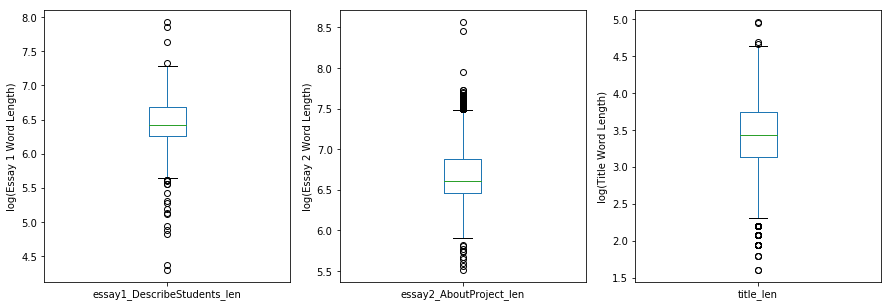

In [6]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
df.essay1_DescribeStudents_len.plot(kind='box')
plt.ylabel('log(Essay 1 Word Length)')
plt.subplot(1,3,2)
df.essay2_AboutProject_len.plot(kind='box')
plt.ylabel('log(Essay 2 Word Length)')
plt.subplot(1,3,3)
df.title_len.plot(kind='box')
plt.ylabel('log(Title Word Length)')
plt.show()

The boxplots above show the three new features added to this data set after the log transform has been applied

### Data Preparation Part 2

In [7]:
# Need description here, maybe a few visualizations

## Modeling and Evaluation

### Modeling and Evaluation 1: Evaluation Metrics

In [8]:
#need something here

### Modeling and Evaluation 2: Train/Test Splits

In [9]:
#need something here

### Classification/Regression Models
We will create three different models for two different tasks.

-Task1:  predict whether an application will be approved or declined

-Task2:  predict whether an application project is one of the three Rs (Reading, Writing, Arithmetic) based on the essay text

### Modeling and Evaluation 3
#### Task 1:  Predicting Application Approval
##### Logistic Regression Model

In [10]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb

cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

# remove the text-based variables for now, as they're not used in the logistic regression
if 'text' in df:
         del df['text'] 
if 'student_desc' in df:
         del df['student_desc'] 
if 'proj_desc' in df:
         del df['proj_desc'] 
    

# we want to predict the X and y data as follows:
if 'project_is_approved' in df:
    y = df['project_is_approved'].values # get the labels we want
    del df['project_is_approved'] # get rid of the class label
    X = df.values # use everything else to predict!
    
#Logisitic regression 10-fold cross-validation 

regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced'] #,'none']
              ,'random_state': [0]
              ,'solver': ['sag'] #['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  

regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   21.3s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:  2.3min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced'], 'random_state': [0], 'solver': ['sag'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [11]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [12]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_



def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 

    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv)
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(y,predictions)
    confMat = confusion_matrix(y,predictions)
    acc = accuracy_score(y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)

In [13]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X, y, cv)

The average accuracy for all cv folds is: 			 0.5857
The average precision for all cv folds is: 			 0.89307
The average recall for all cv folds is: 			 0.58154
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.584468,0.892300,0.580806
1,0.588533,0.896644,0.582509
2,0.579910,0.888178,0.576469
3,0.593091,0.897517,0.588486
4,0.581173,0.894647,0.574725
5,0.588972,0.890916,0.586140
6,0.582876,0.889165,0.579647
7,0.585457,0.895172,0.580616
8,0.591443,0.893705,0.589178
9,0.581118,0.892475,0.576863


In [14]:
EvaluateClassifierEstimator2(classifierEst, X, y, 10)

             precision    recall  f1-score   support

          0       0.21      0.61      0.31     27734
          1       0.89      0.58      0.70    154339

avg / total       0.79      0.59      0.64    182073

[[17023 10711]
 [64703 89636]]
0.5858034963997957


In [15]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)


# first we create a reusable logisitic regression object
lr_clf = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='sag', tol=0.0001, verbose=0, warm_start=False) # get object

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    tic = time.time()
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions
    toc = time.time()
    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print('Training and fitting time:',toc-tic)
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)
====Iteration 0  ====
Training and fitting time: 1.5667860507965088
accuracy 0.5854730193601538
confusion matrix
 [[ 3381  2146]
 [12949 17939]]
====Iteration 1  ====
Training and fitting time: 1.446554183959961
accuracy 0.5876973774543457
confusion matrix
 [[ 3428  2240]
 [12774 17973]]
====Iteration 2  ====
Training and fitting time: 1.27516508102417
accuracy 0.5863792393244542
confusion matrix
 [[ 3408  2097]
 [12965 17945]]


In [16]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X[train_indices]) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data. It uses the last iteration of the loop above for the split.

X_train_scaled = scl_obj.transform(X[train_indices]) # apply to training
X_test_scaled = scl_obj.transform(X[test_indices]) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)  
tic = time.time()
lr_clf.fit(X_train_scaled,y[train_indices])  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions
toc = time.time()

acc = mt.accuracy_score(y[test_indices],y_hat)
conf = mt.confusion_matrix(y[test_indices],y_hat)
print('accuracy:', acc )
print('Training and Fitting Time:', toc-tic)
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.5872854592887546
Training and Fitting Time: 0.8927826881408691
[[ 3408  2097]
 [12932 17978]]
Total_Cost has weight of -0.29699385075799395
project_grade_category_Grades PreK-2 has weight of -0.03772316029127172
teacher_prefix_Teacher has weight of -0.03106512222274373
essay1_DescribeStudents_len has weight of -0.007651613868917098
title_len has weight of 0.02262632689571053
True_Quantity has weight of 0.04029443746491089
three_r has weight of 0.05713024182549292
teacher_number_of_previously_posted_projects has weight of 0.21701367388927742
essay2_AboutProject_len has weight of 0.27197023978106943
Average_item_cost has weight of 0.3751718705399757


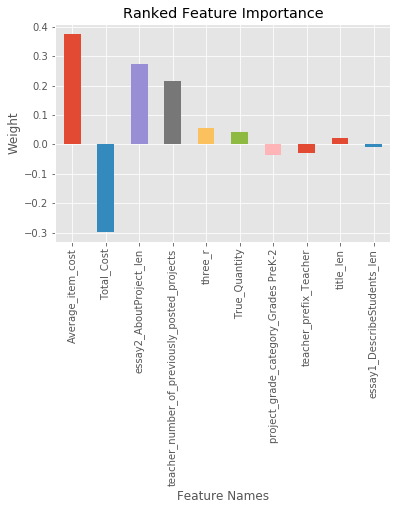

In [17]:
# now let's make a pandas Series with the names and values, and plot them
# reference for code: https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb

%matplotlib inline
plt.style.use('ggplot')

weights = lr_clf.coef_.ravel()
feature_names = df.columns.values

logreg_features = pd.DataFrame({'feature_names': feature_names[:10], 'weights': weights, 'absolute_weights':np.abs(weights)})
logreg_features.sort_values(by='absolute_weights', inplace=True, ascending = False)

weights = pd.Series(logreg_features['weights'].values, index=logreg_features['feature_names'])
px = weights.plot(kind='bar')
px.set_xlabel("Feature Names")
px.set_ylabel("Weight")
px.set_title("Ranked Feature Importance")
plt.show()

##### Decision Tree Classification

In [18]:
cv = StratifiedShuffleSplit(n_splits=1,train_size=0.5)

# Reset dataframe variable
df = df2.copy()

In [19]:
# remove the text-based variables for now, as they're not used in the logistic regression
if 'text' in df:
         del df['text'] 
if 'student_desc' in df:
         del df['student_desc'] 
if 'proj_desc' in df:
         del df['proj_desc'] 
        
# we want to predict the X and y data as follows:
if 'project_is_approved' in df:
    y = df['project_is_approved'].values # get the labels we want
    del df['project_is_approved'] # get rid of the class label
    
    X2 = df.values # use everything else to predict!
else: X2 = df.values

In [20]:

dt_clf = DecisionTreeClassifier()

# now get the training and testing
for train, test in cv.split(X2,y):
    print ('Training Once:')
    # train the decision tree algorithm
    %time dt_clf.fit(X2[train],y[train])
    yhat = dt_clf.predict(X2[test])
    print ('accuracy:', mt.accuracy_score(y[test],yhat))

Training Once:
CPU times: user 890 ms, sys: 8.16 ms, total: 898 ms
Wall time: 898 ms
accuracy: 0.7407183655536028


In [21]:
# from the tutorial: http://www.kaggle.com/c/datasciencebowl/details/tutorial 
def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    y_true : array, shape = [n_samples]
            true class, integers in [0, n_classes - 1)
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    n_samples = actual.shape[0]
    actual[np.arange(n_samples), y_true.astype(int)] = 1
    vectsum = np.sum(actual * np.log(predictions))
    loss = -1.0 / n_samples * vectsum
    return loss

In [22]:
yhat = dt_clf.predict(X2[test])
class_probabilities = dt_clf.predict_proba(X2[test])
print ('Accuracy:', mt.accuracy_score(y[test],yhat))
print ('Log Loss:', multiclass_log_loss(y[test], class_probabilities))

Accuracy: 0.7407183655536028
Log Loss: 8.955270395451084


In [23]:

n_components = 10
pca = PCA(n_components=n_components, svd_solver='randomized')

for train, test in cv.split(X2,y):
    print ('Training Once:')
    
    # transform the data using pca
    %time pca.fit(X2[train])
    X_train = pca.transform(X2[train])
    X_test = pca.transform(X2[test])
    
    # train the decision tree algorithm
    %time dt_clf.fit(X_train,y[train])
    yhat = dt_clf.predict(X_test)
    class_probabilities = dt_clf.predict_proba(X_test)
    
    print ('Accuracy:', mt.accuracy_score(y[test],yhat))
    print ('Log Loss:', multiclass_log_loss(y[test], class_probabilities))

Training Once:
CPU times: user 764 ms, sys: 137 ms, total: 901 ms
Wall time: 384 ms
CPU times: user 2.23 s, sys: 89.3 ms, total: 2.32 s
Wall time: 1.78 s
Accuracy: 0.7426955184534271
Log Loss: 8.886981953545504


In [24]:
log_losses = []
accuracies = []
params = []

%matplotlib inline

Training Once:
Training and Fitting time: 1.2987027168273926
Accuracy: 0.8474846221441125
Log Loss: 0.413194693590955


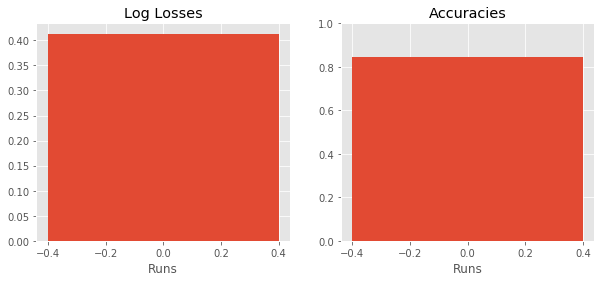

In [25]:
# how to make it generalize a bit better? 

# defaults
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=None, 
                                min_samples_split=2, min_samples_leaf=1, 
                                max_features=None,
                                max_leaf_nodes=None)

# overwrite with prepruning methods
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, 
                                min_samples_split=1000, min_samples_leaf=1, 
                                max_leaf_nodes=None)

for train, test in cv.split(X,y):
    print ('Training Once:')
    tic = time.time()
    # transform the data using pca
    pca.fit(X2[train])
    X_train = pca.transform(X2[train])
    X_test = pca.transform(X2[test])
    
    # train the decision tree algorithm
    dt_clf.fit(X_train,y[train])
    yhat = dt_clf.predict(X_test)
    class_probabilities = dt_clf.predict_proba(X_test)
    toc = time.time()
    # get accuracy and log loss of this training
    acc = mt.accuracy_score(y[test],yhat)
    ll = multiclass_log_loss(y[test], class_probabilities)
    print('Training and Fitting time:',toc-tic)
    print ('Accuracy:', acc)
    print ('Log Loss:', ll)
    
    # save accuracy, log loss, and params of run
    log_losses.append(ll)
    accuracies.append(acc)
    params.append(dt_clf.get_params())
    
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(range(len(log_losses)),log_losses)
plt.title('Log Losses')
plt.xlabel('Runs')

plt.subplot(1,2,2)
plt.bar(range(len(accuracies)),accuracies)
plt.title('Accuracies')
plt.xlabel('Runs')
plt.ylim([0,1])

plt.show()

In [26]:
# a telling example for log loss minimization
class_probabilities = np.ones((len(y[test]),len(np.unique(y))))
print ('Log Loss of "Chance":', multiclass_log_loss(y[test], class_probabilities))

Log Loss of "Chance": 0.6931471805599453


##### Naive Bayes - Multinomial

In [28]:

#reset dataframe to original state
df = df2.copy()
y = df['project_is_approved'].values
y2 = df['three_r'].values
X_train, X_test, y_proj_train, y_proj_test = train_test_split(df, y)

if 'project_is_approved' in X_train: del X_train['project_is_approved']
if 'project_is_approved' in X_test: del X_test['project_is_approved']


In [29]:
# Create and fit our Tfidf Vectorizer
vectorizer = TfidfVectorizer()
%time text = vectorizer.fit_transform(X_train['text'])

# Transform the test data to the vectorizer that was created above.
x_test = vectorizer.transform(X_test['text'])

mnb_proj = MultinomialNB()
tic = time.time()
mnb_proj.fit(text, y_proj_train)
mnb_proj.predict(x_test)
toc = time.time()
print("Accuracy of a Multinomial NB classifier on the project approval column:",
      accuracy_score(mnb_proj.predict(x_test), y_proj_test))
print('Training and Fitting Time:', toc-tic)

CPU times: user 22.7 s, sys: 970 ms, total: 23.7 s
Wall time: 23.8 s
Accuracy of a Multinomial NB classifier on the project approval column: 0.8513148355631714
Training and Fitting Time: 0.1421949863433838


#### Task 2: Predicting Core Academic Competency Projects (Reading, Writing, Math)
##### Preparing the Data

In [30]:
#reset dataframe to original state
df = df2.copy()
y = df['project_is_approved'].values
y2 = df['three_r'].values
X_train, X_test, y_3r_train, y_3r_test = train_test_split(df, y2)

if 'project_is_approved' in X_train: del X_train['project_is_approved']
if 'project_is_approved' in X_test: del X_test['project_is_approved']
    
if 'three_r' in X_train: del X_train['three_r']
if 'three_r' in X_test: del X_test['three_r']


X_train_text = X_train['text']
X_test_text = X_test['text']
if 'text' in X_train: del X_train['text']
if 'text' in X_test: del X_test['text']

In [32]:
# Use the same TFIDF Vectorizer as before
vectorizer2 = TfidfVectorizer()
# Grab the Three R's column as our testing variable.
print('TfidfVectorizer Training Time:')
%time train_text = vectorizer2.fit_transform(X_train_text)

# Transform the test data to the vectorizer that was created above.
test_text = vectorizer2.transform(X_test_text)

mnb = MultinomialNB()
tic = time.time()
mnb.fit(train_text, y_3r_train)
toc = time.time()

print("Accuracy of a Multinomial NB classifier on the Three R's column:",
      accuracy_score(mnb.predict(test_text), y_3r_test))
print('Training and Fitting Time:', toc-tic)

TfidfVectorizer Training Time:
CPU times: user 23.1 s, sys: 977 ms, total: 24.1 s
Wall time: 24.3 s
Accuracy of a Multinomial NB classifier on the Three R's column: 0.8309497133065313
Training and Fitting Time: 0.11652994155883789


#### Multinomial Naive-Bayes

In [37]:
vectorizer3 = TfidfVectorizer()
all_text = vectorizer3.fit_transform(df['text'])
scores = EvaluateClassifierEstimator(mnb, all_text,y2,10)

The average accuracy for all cv folds is: 			 0.83162
The average precision for all cv folds is: 			 0.82716
The average recall for all cv folds is: 			 0.96112
*********************************************************
Cross Validation Fold Mean Error Scores


#### Random Forest Classifier

In [42]:
rfc = RandomForestClassifier()
%time scores2 = EvaluateClassifierEstimator(rfc, all_text, y2, 10)

The average accuracy for all cv folds is: 			 0.82324
The average precision for all cv folds is: 			 0.84497
The average recall for all cv folds is: 			 0.91652
*********************************************************
Cross Validation Fold Mean Error Scores
CPU times: user 16min 55s, sys: 14.1 s, total: 17min 9s
Wall time: 16min 24s


In [44]:
scores2

,Accuracy,Precision,Recall
0,0.825242,0.845203,0.919618
1,0.816344,0.840950,0.910783
2,0.824253,0.849275,0.911565
3,0.824857,0.846370,0.917116
4,0.826395,0.848689,0.916178
5,0.824363,0.845472,0.917664
6,0.820014,0.841323,0.916647
7,0.823300,0.846449,0.914295
8,0.825168,0.843994,0.921411
9,0.822476,0.841970,0.919925


In [33]:
#reset dataframe to original state
df = df2.copy()
y3 = df.pop('three_r')
X3 = df.copy()

train2, test2, y_proj_train2, y_proj_test2  = train_test_split(X3, y3, test_size=0.1, train_size=0.2, stratify=y3)

vectorizer2 = TfidfVectorizer()
text2 = vectorizer2.fit_transform(train2['text'])

# create variables we are more familiar with
X_knn = text2
y_knn = y_proj_train2
yhat = np.zeros(y_knn.shape) # we will fill this with predictions

#scl = StandardScaler()
#X_knn = scl.fit_transform(X_knn)

# create cross validation iterator
cv_knn = StratifiedKFold(n_splits=10)

# get a handle to the classifier object, which defines the type
clf_knn = KNeighborsClassifier(n_neighbors=3)

# NOTE: you can parallelize this using the cross_val_predict method
%time yhat = cross_val_predict(clf_knn,X_knn,y_knn)

total_accuracy = mt.accuracy_score(y_knn, yhat)
print ('KNN accuracy', total_accuracy)

CPU times: user 1min 44s, sys: 14.2 s, total: 1min 58s
Wall time: 1min 58s
KNN accuracy 0.818119404624595


### Modeling and Evaluation 4: Analyze Results of Chosen Models

In [ ]:
#need something here

### Modeling and Evaluation 5: Model Advantages

In [ ]:
#need something here

### Modeling and Evaluation 6: Model Attribute Importance

In [ ]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb


# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X[train_indices]) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data. It uses the last iteration of the loop above for the split.

X_train_scaled = scl_obj.transform(X[train_indices]) # apply to training
X_test_scaled = scl_obj.transform(X[test_indices]) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)  
lr_clf.fit(X_train_scaled,y[train_indices])  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y[test_indices],y_hat)
conf = mt.confusion_matrix(y[test_indices],y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

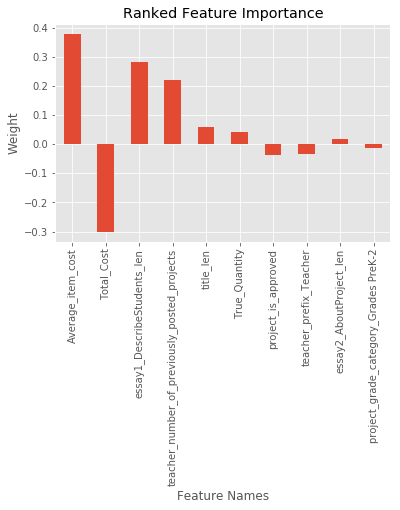

In [96]:
# now let's make a pandas Series with the names and values, and plot them
# reference for code: https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
%matplotlib inline
plt.style.use('ggplot')

weights = lr_clf.coef_.ravel()
feature_names = df.columns.values

logreg_features = pd.DataFrame({'feature_names': feature_names[:10], 'weights': weights, 'absolute_weights':np.abs(weights)})
logreg_features.sort_values(by='absolute_weights', inplace=True, ascending = False)

weights = pd.Series(logreg_features['weights'].values, index=logreg_features['feature_names'])
px = weights.plot(kind='bar')
px.set_xlabel("Feature Names")
px.set_ylabel("Weight")
px.set_title("Ranked Feature Importance")
plt.show()

In [ ]:
#need something here

## Deployment

In [ ]:
#need something here

## Exceptional Work

In [ ]:
#need something here